# AirQ Google Collab ☁️

# Configure DAGsHub & Git

In [1]:
import requests
import getpass
import datetime

In [2]:
#@title Set Environment Variables

#@markdown Enter the repository name for the project:
REPO_NAME= "AirQ" #@param {type:"string"}

#@markdown Enter the username of your DAGsHub account:
USER_NAME = "Abuynits" #@param {type:"string"}

#@markdown Enter the email for your DAGsHub account:
EMAIL = "abuynits@gmail.com" #@param {type:"string"}

#@markdown ---

In [3]:
r = requests.post('https://dagshub.com/api/v1/user/tokens', 
                  json={"name": f"colab-token-{datetime.datetime.now()}"}, 
                  auth=(USER_NAME, getpass.getpass('DAGsHub password:')))
r.raise_for_status()
TOKEN=r.json()['sha1']

DAGsHub password:··········


**Configure Git**

In [4]:
!git config --global user.email {EMAIL}
!git config --global user.name {USER_NAME}

**Clone the Repository**

In [5]:
!git clone https://dagshub.com/Abuynits/boilermakeX.git
!git clone https://dagshub.com/briang3389/AirQ.git
%cd AirQ

Cloning into 'boilermakeX'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 58 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (58/58), 3.05 MiB | 11.78 MiB/s, done.
Cloning into 'AirQ'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 154 (delta 65), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (154/154), 919.83 KiB | 6.34 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/AirQ


## Imports

In [6]:
import pandas as pd
import os
import numpy as np
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random

In [7]:
# check GPU Access
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Sun Jan 22 05:00:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### DATA Filtering and Preparation

Filters the data and prepares it for ML

In [48]:

input_data_cols = ["CO(GT)", "PT08.S1(CO)", "NMHC(GT)"] # add features to end to make itself predict the output col - lstm not limit to 1 feature
#input_data_cols = ["CO(GT)"]
input_data_features = len(input_data_cols) # length of input features to be predicted
output_data_cols = ["CO(GT)"] # output collumn(s) of interest
output_data_features = len(output_data_cols) # length of output features to be predicted
percent = 0.8 # test-train split percentage
lookback = 20 # number of units used to make prediction
predict = 10 # number of units that will be predicted
batch_size = 2048 # number of examples run through in parallel
shuffle_train_data = True # whether you want to shuffle data during training or not

In [49]:
originaldf = pd.read_excel('/content/boilermakeX/AirQualityUCI.xlsx')
originaldf.replace({-200: np.NaN}, inplace=True) # interpolate missing values
originaldf.replace({'-200': np.NaN}, inplace=True)
for i in range(2, len(list(originaldf.columns))):
    originaldf[list(originaldf.columns)[i]] = originaldf[list(originaldf.columns)[i]].interpolate()

scaler = MinMaxScaler()
df = originaldf.copy()
df[input_data_cols] = scaler.fit_transform(originaldf[input_data_cols])
print("number of rows: " + str(len(df.index)))

number of rows: 9357


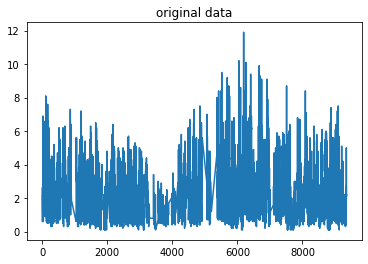

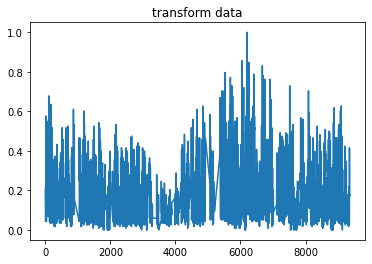

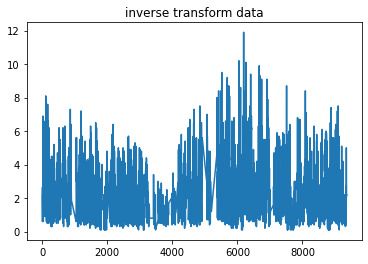

In [50]:
# test for proper scalling and un scalling
plt.title("original data")
plt.plot(originaldf["CO(GT)"])
plt.show()

plt.title("transform data")
plt.plot(df["CO(GT)"])
plt.show()

plt.title("inverse transform data")
testdf = df.copy()
testdf[input_data_cols] = scaler.inverse_transform(df[input_data_cols])
plt.plot(testdf["CO(GT)"])
plt.show()

## Test Train Split

In [51]:
inputcolsdf = df[input_data_cols].copy()
outputcolsdf = df[output_data_cols].copy()
testingSetInput = []
testingSetOutput = []
for i in range(len(df.index)-(lookback+predict-1)):
  #print(i, " ", i+lookback, " ", i+lookback+predict)
  testingSetInput.append(inputcolsdf.iloc[list(range(i, i+lookback)),:].to_numpy())
  testingSetOutput.append(outputcolsdf.iloc[list(range(i+lookback, i+lookback+predict)),:].to_numpy())

print(np.asarray(testingSetInput).shape)
print(np.asarray(testingSetOutput).shape)

(9328, 20, 3)
(9328, 10, 1)


## Load Data from DVS

In [52]:
def split_test_train_data(ts_inp,ts_out,shuffle = False,percent_train = percent):
  len_data = len(df.index)
  print("shuffle data:",shuffle)
  print(ts_out[0])
  if shuffle:
    all_data_arr = np.array((ts_inp,ts_out),dtype=object).T
    #print(all_data_arr.shape)
    np.random.shuffle(all_data_arr)
    all_data_arr = all_data_arr.T
    #print(all_data_arr.shape)
    ts_inp,ts_out = all_data_arr[0],all_data_arr[1]
  print(ts_out[0])
    #for x in rand_arr_indexes[0:int(percent*len_data)]:
    #  train_x.append()
      

  train_x = np.asarray(ts_inp[0:int(percent*len_data)])
  print("train_x",train_x.shape)
  train_y = np.asarray(ts_out[0:int(percent*len_data)])
  print("train_y",train_y.shape)
  valid_x = np.asarray(ts_inp[int(percent*len_data):])
  print("valid_x",valid_x.shape)
  valid_y = np.asarray(ts_out[int(percent*len_data):])
  print("valid_y",valid_y.shape)

  return train_x,train_y,valid_x,valid_y

In [53]:
# def getValidDataFrom(file_path):
#   if not os.path.exists(file_path):
#     raise ValueError('No such file path exist!')
#   pass


# valid_x = getValidDataFrom("VALID_X_FILE_PATH")
# valid_y = getValidDataFrom("VALID_Y_FILE_PATH")

# train_x = getValidDataFrom("train_X_FILE_PATH")
# train_y = getValidDataFrom("train_Y_FILE_PATH")
train_x,train_y,valid_x,valid_y = split_test_train_data(testingSetInput.copy(),testingSetOutput.copy(),shuffle = True)




shuffle data: True
[[0.23728814]
 [0.1779661 ]
 [0.1779661 ]
 [0.23728814]
 [0.39830508]
 [0.57627119]
 [0.50847458]
 [0.3220339 ]
 [0.11864407]
 [0.07627119]]
[[0.30508475]
 [0.45762712]
 [0.44915254]
 [0.70338983]
 [0.56779661]
 [0.37288136]
 [0.20338983]
 [0.12711864]
 [0.13559322]
 [0.13559322]]
train_x (7485,)
train_y (7485,)
valid_x (1843,)
valid_y (1843,)


## Dataloader to prep and process the data

In [54]:
def disp_ds_info(dl,count):
  inp_seq = next(iter(dl))[0]
  out_seq = next(iter(dl))[1]
  print(" train seq:",inp_seq.shape)
  print(" test seq",out_seq.shape)
  for i in range(count):
    print(" Input seq:",inp_seq[i])
    print(" Out seq:",out_seq[i])

class air_quality_ds(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        self.data_len = len(x)

    def __len__(self):
        return self.data_len

    def __getitem__(self, i):
        train_ex = torch.from_numpy(self.x[i]).float()
        test_ex = torch.from_numpy(self.y[i]).float()
        return (train_ex,test_ex)
    
valid_ds = air_quality_ds(valid_x,valid_y)
print("validation batches:",len(valid_ds))

train_ds = air_quality_ds(train_x,train_y)
print("train batches:",len(train_ds))

# create dataloaders
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
print(f"batches in valid_dl: {len(valid_dl)}")
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
print(f"batches in train_dl: {len(train_dl)}")

print("====Train DS====")
disp_ds_info(train_dl,2)
print("====Validation DS====")
disp_ds_info(valid_dl,4)



validation batches: 1843
train batches: 7485
batches in valid_dl: 1
batches in train_dl: 4
====Train DS====
 train seq: torch.Size([2048, 20, 3])
 test seq torch.Size([2048, 10, 1])
 Input seq: tensor([[0.2034, 0.3759, 0.2267],
        [0.3136, 0.4804, 0.2267],
        [0.2712, 0.4025, 0.2267],
        [0.2034, 0.3571, 0.2267],
        [0.2203, 0.3890, 0.2267],
        [0.2373, 0.3774, 0.2267],
        [0.2542, 0.4237, 0.2267],
        [0.3305, 0.4348, 0.2267],
        [0.2542, 0.3643, 0.2267],
        [0.2203, 0.3790, 0.2267],
        [0.1356, 0.2542, 0.2267],
        [0.1186, 0.2634, 0.2267],
        [0.1102, 0.2291, 0.2267],
        [0.1102, 0.2436, 0.2267],
        [0.0847, 0.1725, 0.2267],
        [0.0847, 0.1894, 0.2267],
        [0.0636, 0.1294, 0.2267],
        [0.0424, 0.1508, 0.2267],
        [0.0593, 0.1713, 0.2267],
        [0.0763, 0.2273, 0.2267]])
 Out seq: tensor([[0.1356],
        [0.1610],
        [0.1780],
        [0.2627],
        [0.2966],
        [0.3136],
       

## Model Params

In [125]:
lstm_inp_size = input_data_features # number of input features in lstm
lstm_out_size = output_data_features # number of output features in lstm
lstm_hidden_count = 8 # number of lstm cells
lstm_dropout = 0.15 # none lol
lstm_layer_count = 4 # number of layers in lstm cell
lstm_input_seq_len = lookback # length of input sequence to LSTM
lstm_verbose = False

In [126]:
def print_model(model):
  sum = 0
  print(model)
  for param in model.parameters():
      if param.requires_grad:
          sum += param.numel()
  print("total trainable parameters:",sum)

## Seq2Seq Model

In [127]:
seq2seq_verbose = False
print_once = False

In [128]:
class encoder_lstm(nn.Module):
  def __init__(self, inp_size, hid_size, dropout, layer_count):
        super(encoder_lstm, self).__init__()
        self._input_size = inp_size  # number of input features
        self._hidden_size = hid_size  # number of features in hidden state
        self._layer_count = layer_count  # number of stacked LSTM's
        self._dropout = dropout

        self._lstm = nn.LSTM(input_size=self._input_size,
                            hidden_size=self._hidden_size,
                            num_layers=self._layer_count, 
                            dropout=self._dropout)
        
        self._drop = nn.Dropout(dropout)
  def forward(self,x):
    # input shape: (seq_len, count units in batch, input size)
    if seq2seq_verbose:
      print("enc: inp shape",x.shape)
    out,(self.hn,self.cn) = self._lstm(x)
    if seq2seq_verbose:
      #print("enc: out shape",out.shape)
      print("enc: hn shape",self.hn.shape)

    return out.to(device), (self.hn,self.cn)

  def init_hidden(self,batch_size):
    (h_0,c_0) = (torch.randn(self._layer_count,batch_size,self._hidden_size).requires_grad_().to(device),    
      torch.randn(self._layer_count,batch_size,self._hidden_size).requires_grad_().to(device))
    return (h_0,c_0)
class decoder_lstm(nn.Module):
  def __init__(self,inp_size,out_size, hid_size, layer_count,drop):
    super(decoder_lstm,self).__init__()
    self._inp_feature_size = inp_size # number of input features
    self._out_feature_size = out_size # number of input features
    self._hid_size = hid_size # size of hidden size
    self._layer_count = layer_count # number of hidden lstm cells
    self._dropout = drop

    self._lstm = nn.LSTM(input_size=self._inp_feature_size, 
                        hidden_size = self._hid_size, 
                        num_layers = self._layer_count,
                        dropout=self._dropout)
    
    self._l_in = nn.Linear(self._hid_size,self._inp_feature_size)
    self._l_out = nn.Linear(self._hid_size,self._out_feature_size)

  def forward(self,x,enc_hidden_states):
    # x: 2d - the last input time step
    # enc_hidden_states: the last hidden decoder time step
    if seq2seq_verbose:
      print("dec: inp shape",x.shape)
    #lstm_out, (hn, cn) = self._lstm(x,enc_hidden_states)
    lstm_out, (self.hn,self.cn) = self._lstm(x.unsqueeze(0),enc_hidden_states)
    if seq2seq_verbose:
      print("dec: lstm out shape",lstm_out.shape)
      print("dec: hn shape",self.hn[0].shape)
    
    output = self._l_in(lstm_out.squeeze(0))
    final_output = self._l_out(lstm_out.squeeze(0))

    if seq2seq_verbose:
      print("dec: output shape", output.shape)
      print("dec: final output shape", final_output.shape)
      print("dec: final hn shape", self.hn.shape)
    return final_output, output, (self.hn,self.cn)

class seq2seq(nn.Module):
  def __init__(self,inp_size=input_data_features,out_size = output_data_features,hid_size=lstm_hidden_count,layer_count=lstm_layer_count,dropout=lstm_dropout):
    super(seq2seq,self).__init__()
    self._inp_size = inp_size
    self._hid_size = hid_size
    self._layer_count = layer_count
    self._dropout = dropout
    self._out_size = out_size
    
    self._enc = encoder_lstm(inp_size=self._inp_size, hid_size=self._hid_size,dropout=self._dropout,layer_count=self._layer_count)
    self._dec = decoder_lstm(inp_size=self._inp_size, out_size = self._out_size, hid_size=self._hid_size,drop=self._dropout,layer_count=self._layer_count)

    print_model(self)
    self.model_name = "seq2seq"


  def forward(self,inp):
    outputs = torch.zeros(predict,inp.size(1),self._out_size)
    enc_hidden = self._enc.init_hidden(inp.size(1))

    if seq2seq_verbose:
      print("============")
      print("seq2seq: input",inp.shape)
      print("seq2seq: outputs",outputs.shape)
      print("seq2seq: hn",enc_hidden[0].shape)

    enc_out,enc_hidden = self._enc(inp)

    if seq2seq_verbose:
      print("seq2seq: enc_out",enc_out.shape)
      print("seq2seq: enc_hidden",enc_hidden[0].shape)

    dec_inp = inp[-1,:,:] # get the last element
    dec_hidden = enc_hidden # enc hidden is the last hidden state of the elements

    if seq2seq_verbose:
      print("seq2seq: dec_inp",dec_inp.shape)
      print("seq2seq: dec_hidden", dec_hidden[0].shape)

    for p in range(predict):
      final_dec_out,dec_out,dec_hidden = self._dec(dec_inp,dec_hidden)
      if seq2seq_verbose:
        print(" seq2seq: final_dec_out",final_dec_out.shape)
        print(" seq2seq: dec_out", dec_out.shape)
        print(" seq2seq: dec_hidden hn",dec_hidden[0].shape)
      outputs[p] = final_dec_out
      dec_inp = dec_out
    if seq2seq_verbose:
      print("seq2seq: outputs",outputs.shape)
    if print_once:
      print(outputs)
    #print(outputs)
    return outputs.to(device)


  def predict_seq(self,x):
    x = x.unsqueeze(1) # add in dim of 1
    (hn,cn) = self._enc.init_hidden(1)
    enc_out, (hn,cn) = self._enc(x)
  
    outputs = torch.zeros(predict,output_data_features)
    dec_inp = x[-1,:,:] # get the last element
    dec_hidden = (hn,cn) # enc hidden is the last hidden state of the elements

    for p in range(predict):
      final_dec_out,dec_out,dec_hidden = self._dec(dec_inp,dec_hidden)
      if seq2seq_verbose:
        print(" seq2seq: final_dec_out",final_dec_out.shape)
        print(" seq2seq: dec_out", dec_out.shape)
        print(" seq2seq: dec_hidden hn",dec_hidden[0].shape)
      outputs[p] = final_dec_out
      dec_inp = dec_out
    if seq2seq_verbose:
      print("seq2seq: outputs",outputs.shape)
    return outputs


## LSTM Model

In [129]:
class lstm(nn.Module):
  def __init__(self,inp_size=lstm_inp_size,out_size=lstm_out_size,hidden_size=lstm_hidden_count,layer_count=lstm_layer_count,seq_len=lstm_input_seq_len,dropout=0):
    super(lstm,self).__init__()
    self.model_name = "lstm"
    self.inp_size = inp_size
    self.out_size = out_size
    self.hid_size = hidden_size
    self.layer_count = layer_count
    self.seq_len = seq_len
    self.drop = dropout
    
    self.lstm = nn.LSTM(input_size=self.inp_size, hidden_size=self.hid_size, num_layers=self.layer_count, batch_first=True, dropout=self.drop)

    self.fc = nn.Linear(hidden_size,out_size)

    print_model(self)

  def forward(self,inp):
    if lstm_verbose:
      print("inp shape:",inp.shape) 
      print("hn shape:",hn.shape)
      print("cn shape:",cn.shape)
    (hn,cn) = self.init_hidden(inp.size(0))
    # try with (hn,cn)
    lstm_out,hidden = self.lstm(inp,(hn,cn))
    out = self.fc(hn[0]).flatten()
    if lstm_verbose:
      print("hn[0] shape:", hn[0].shape)
      print("out lstm shape:", out.shape)
    return out

  def init_hidden(self,b_size):
    h_0 = torch.randn(self.layer_count, b_size, self.hid_size).to(device)
    c_0 = torch.randn(self.layer_count, b_size, self.hid_size).to(device)
    return(h_0,c_0)


## Training and Testing Loop

In [141]:
from torch.optim.lr_scheduler import ExponentialLR
train_loss = [] # track training loss
valid_loss = [] # track validation loss
learning_rate = 0.0001 # the learning rate
n_epochs = 1000 # number of epochs
GAMMA = 0.9
#model = lstm().to(device) # TODO create the model
model = seq2seq().to(device)
model_name = model.model_name

print(model_name)
loss_func = nn.MSELoss()
optim = optimizer.Adam(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optim, gamma=GAMMA)

seq2seq(
  (_enc): encoder_lstm(
    (_lstm): LSTM(3, 8, num_layers=4, dropout=0.15)
    (_drop): Dropout(p=0.15, inplace=False)
  )
  (_dec): decoder_lstm(
    (_lstm): LSTM(3, 8, num_layers=4, dropout=0.15)
    (_l_in): Linear(in_features=8, out_features=3, bias=True)
    (_l_out): Linear(in_features=8, out_features=1, bias=True)
  )
)
total trainable parameters: 4324
seq2seq


In [142]:
num_epochs_run = 0
def train_epoch(dl,epoch):
  print_once = True
  model.train(True)

  epoch_train_loss = 0.
  # loop over training batches
  times_run = 0

  for i, (x,y) in enumerate(dl):
    optim.zero_grad() # zero gradients
    x= x.to(device)
    y= y.to(device)

    if model_name == "seq2seq":
      x = x.swapaxes(0, 1)
      y = y.swapaxes(0, 1)
    model_out = model.forward(x)

    # squeeze the tensors to account for 1 dim sizes
    model_out = model_out.squeeze()
    y = y.squeeze()
    
    loss = loss_func(model_out,y)
    epoch_train_loss += loss.item()*x.size(0)

    times_run += x.size(0)

    # compute the loss
    loss.backward()
    # step the optimizer
    optim.step()
  
  return epoch_train_loss/times_run

def test_epoch(dl,epoch):
  model.train(False)
  epoch_test_loss = 0.
  times_run = 0
  # loop over testing batches
  for i, (x,y) in enumerate(dl):
    model_out = model(x)
    # squeeze tensors to account for 1 dim sizes
    model_out = model_out.squeeze()
    y = y.squeeze()

    loss = loss_func(model_out,y)
    epoch_test_loss += loss.item()*x.size(0)
    times_run += x.size(0)

  return epoch_test_loss/times_run


for e in range(n_epochs):
  avg_train_loss = train_epoch(train_dl,e)
  avg_valid_epoch = train_epoch(valid_dl,e)
  num_epochs_run += 1
  train_loss.append(avg_train_loss)
  valid_loss.append(avg_valid_epoch)
  scheduler.step()
  print(f"epoch {e}: avg train loss: {avg_train_loss} avg val loss: {avg_valid_epoch}")

epoch 0: avg train loss: 0.01621731510385871 avg val loss: 0.015294506214559078
epoch 1: avg train loss: 0.016105364076793194 avg val loss: 0.015193699859082699
epoch 2: avg train loss: 0.016025684541091323 avg val loss: 0.015101183205842972
epoch 3: avg train loss: 0.01589633896946907 avg val loss: 0.01498386263847351
epoch 4: avg train loss: 0.015824001049622893 avg val loss: 0.014914999715983868
epoch 5: avg train loss: 0.015711308224126697 avg val loss: 0.014869259670376778
epoch 6: avg train loss: 0.015696388902142644 avg val loss: 0.014816176146268845
epoch 7: avg train loss: 0.01566472928971052 avg val loss: 0.01475465763360262
epoch 8: avg train loss: 0.01562722073867917 avg val loss: 0.014736125245690346
epoch 9: avg train loss: 0.015597611432895064 avg val loss: 0.014713269658386707
epoch 10: avg train loss: 0.015612804796546698 avg val loss: 0.014682899229228497
epoch 11: avg train loss: 0.01555949030444026 avg val loss: 0.014664585702121258
epoch 12: avg train loss: 0.01553

KeyboardInterrupt: ignored

In [143]:
train_x,train_y,valid_x,valid_y = split_test_train_data(testingSetInput.copy(),testingSetOutput.copy(),shuffle = False)

shuffle data: False
[[0.23728814]
 [0.1779661 ]
 [0.1779661 ]
 [0.23728814]
 [0.39830508]
 [0.57627119]
 [0.50847458]
 [0.3220339 ]
 [0.11864407]
 [0.07627119]]
[[0.23728814]
 [0.1779661 ]
 [0.1779661 ]
 [0.23728814]
 [0.39830508]
 [0.57627119]
 [0.50847458]
 [0.3220339 ]
 [0.11864407]
 [0.07627119]]
train_x (7485, 20, 3)
train_y (7485, 10, 1)
valid_x (1843, 20, 3)
valid_y (1843, 10, 1)


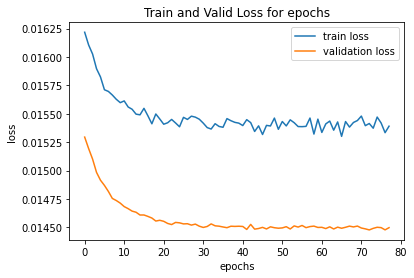

In [144]:
plt.plot(range(0, len(train_loss)), train_loss, label="train loss")
plt.plot(range(0, len(train_loss)), valid_loss, label="validation loss")
plt.legend()
plt.title("Train and Valid Loss for epochs")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

In [1]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

pred_arr = []
ground_truth = []


for i in range(len(train_x)):
  x =  torch.from_numpy(train_x[i]).to(torch.float32)
  y =  torch.from_numpy(train_y[i]).squeeze().to(torch.float32)
  pred = model.predict_seq(x.to_device)

  if predict == 1:
    save_pred = pred.detach().item()
  else:
    save_pred= pred.squeeze().detach().numpy()
    y = y.detach().numpy()
    print(y)
    print(save_pred)
    plt.plot(range(0,len(save_pred)), save_pred, label="prediction")
    plt.plot(range(0,len(save_pred)), y, label="actual")
    plt.legend()
    plt.title("Air Quality Predictions")
    plt.ylabel("prediction")
    plt.xlabel("time step (in hrs)")
    plt.show()
  #print(x.shape,x)
  #print(y.shape,y)
  #print(pred.shape,pred)

#  x_axis.append(i)
#  pred_arr.append(save_pred)
#  ground_truth.append(y)

plt.plot(x_axis, pred_arr, label="prediction")
plt.plot(x_axis, ground_truth, label="actual")
plt.legend()
plt.title("Air Quality Predictions")
plt.ylabel("prediction")
plt.xlabel("time step (in hrs)")
plt.show()

NameError: ignored